In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_PI, optimizer_EI, optimizer_UCB, max_PI, max_EI, max_UCB

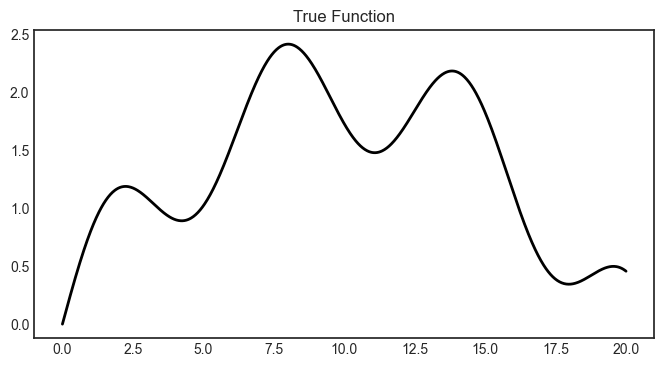

In [2]:
# generating the data
X = np.linspace(0, 20, 1000).reshape(-1, 1)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

# assembling initial training set
X_initial, y_initial = X[150].reshape(1, -1), y[150].reshape(1, -1)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 4))
    plt.plot(X, y, c='k', linewidth=2)
    plt.title('True Function')
    plt.show()

# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)

tr = 0.1
PI_tr = partial(optimizer_PI, tradeoff=tr)
PI_tr.__name__ = 'optimizer_PI, tradeoff = %1.1f' % tr
max_PI_tr = partial(max_PI, tradeoff=tr)

acquisitions = zip(
    [PI_tr, optimizer_EI, optimizer_UCB],
    [max_PI_tr, max_EI, max_UCB],
)
#acquisitions = max_UCB

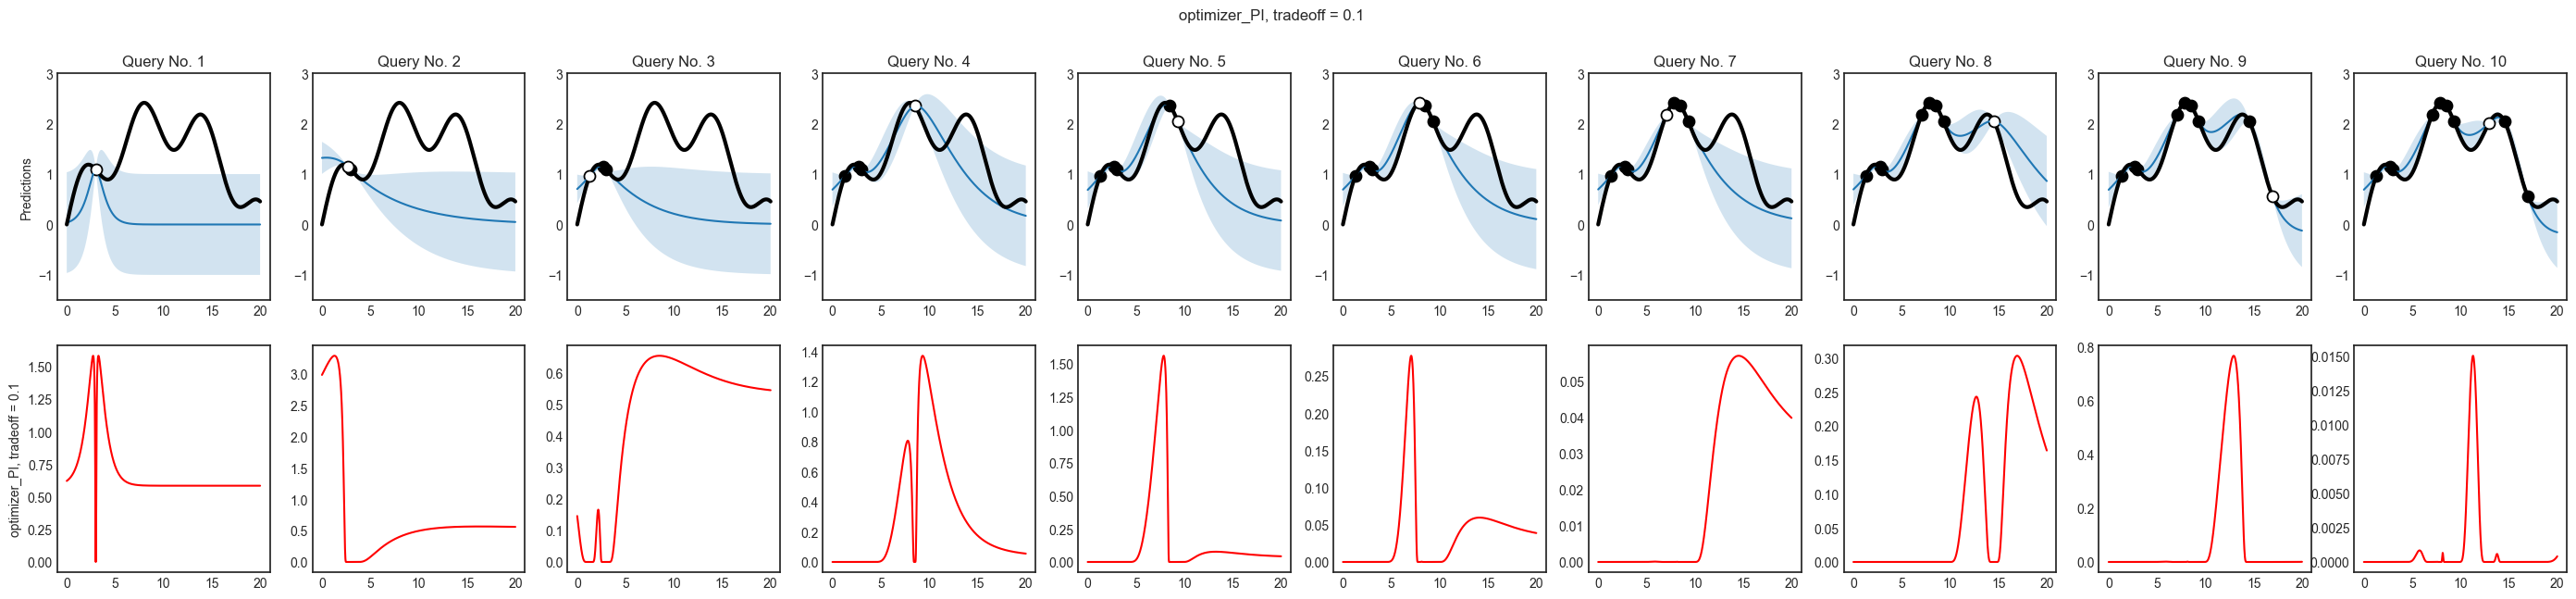

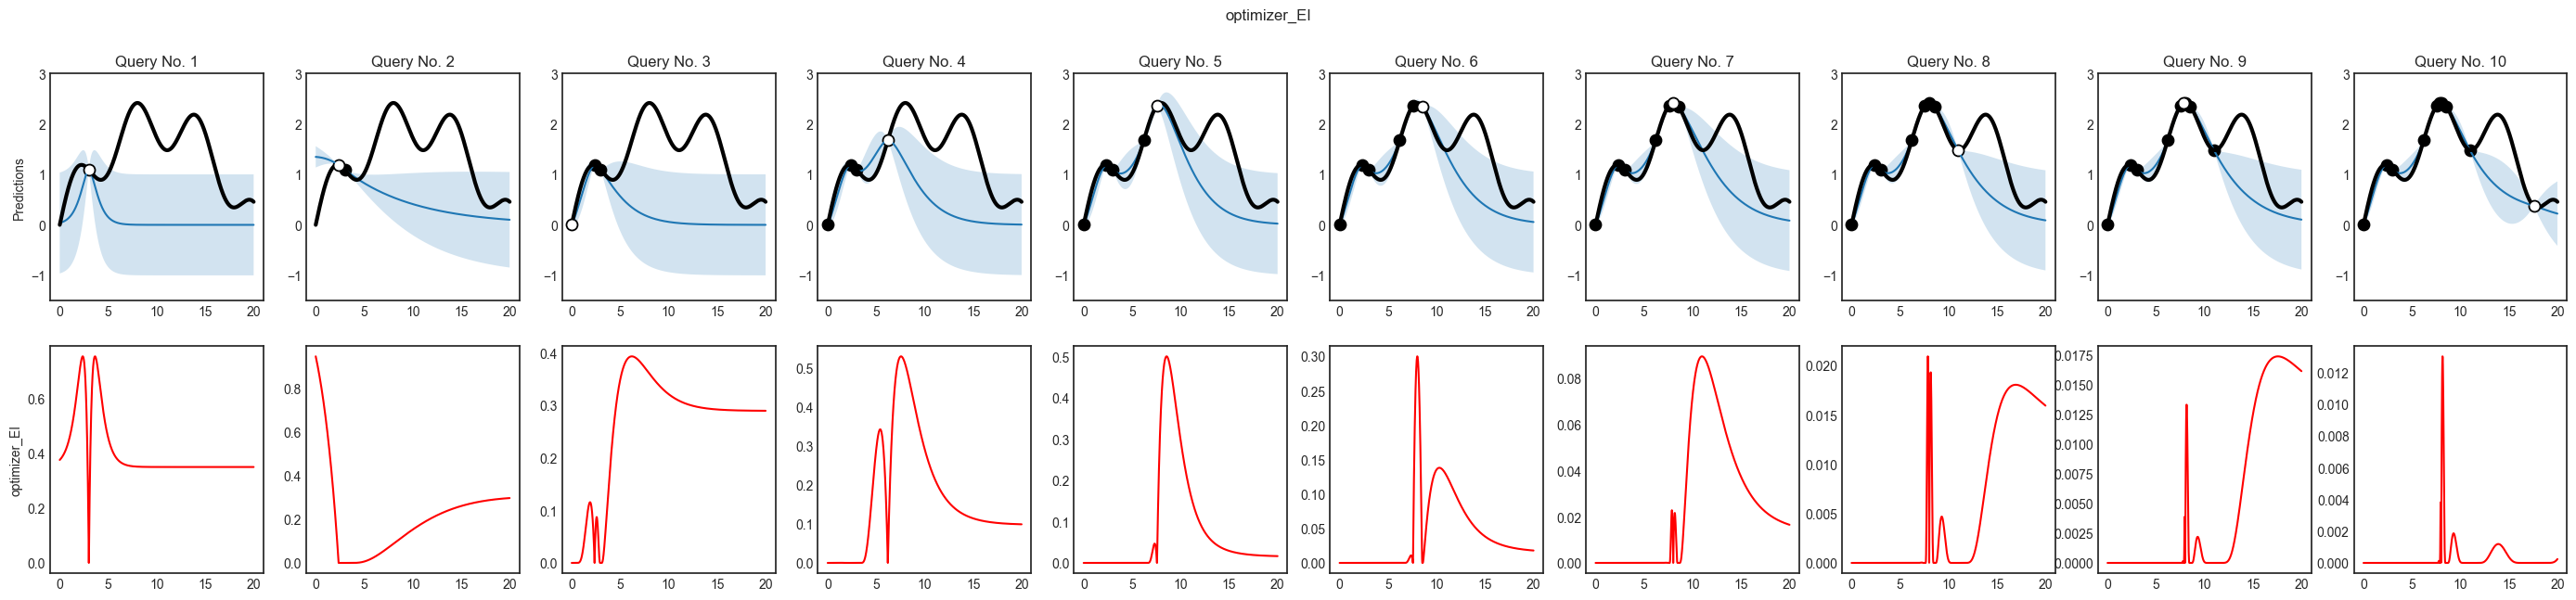

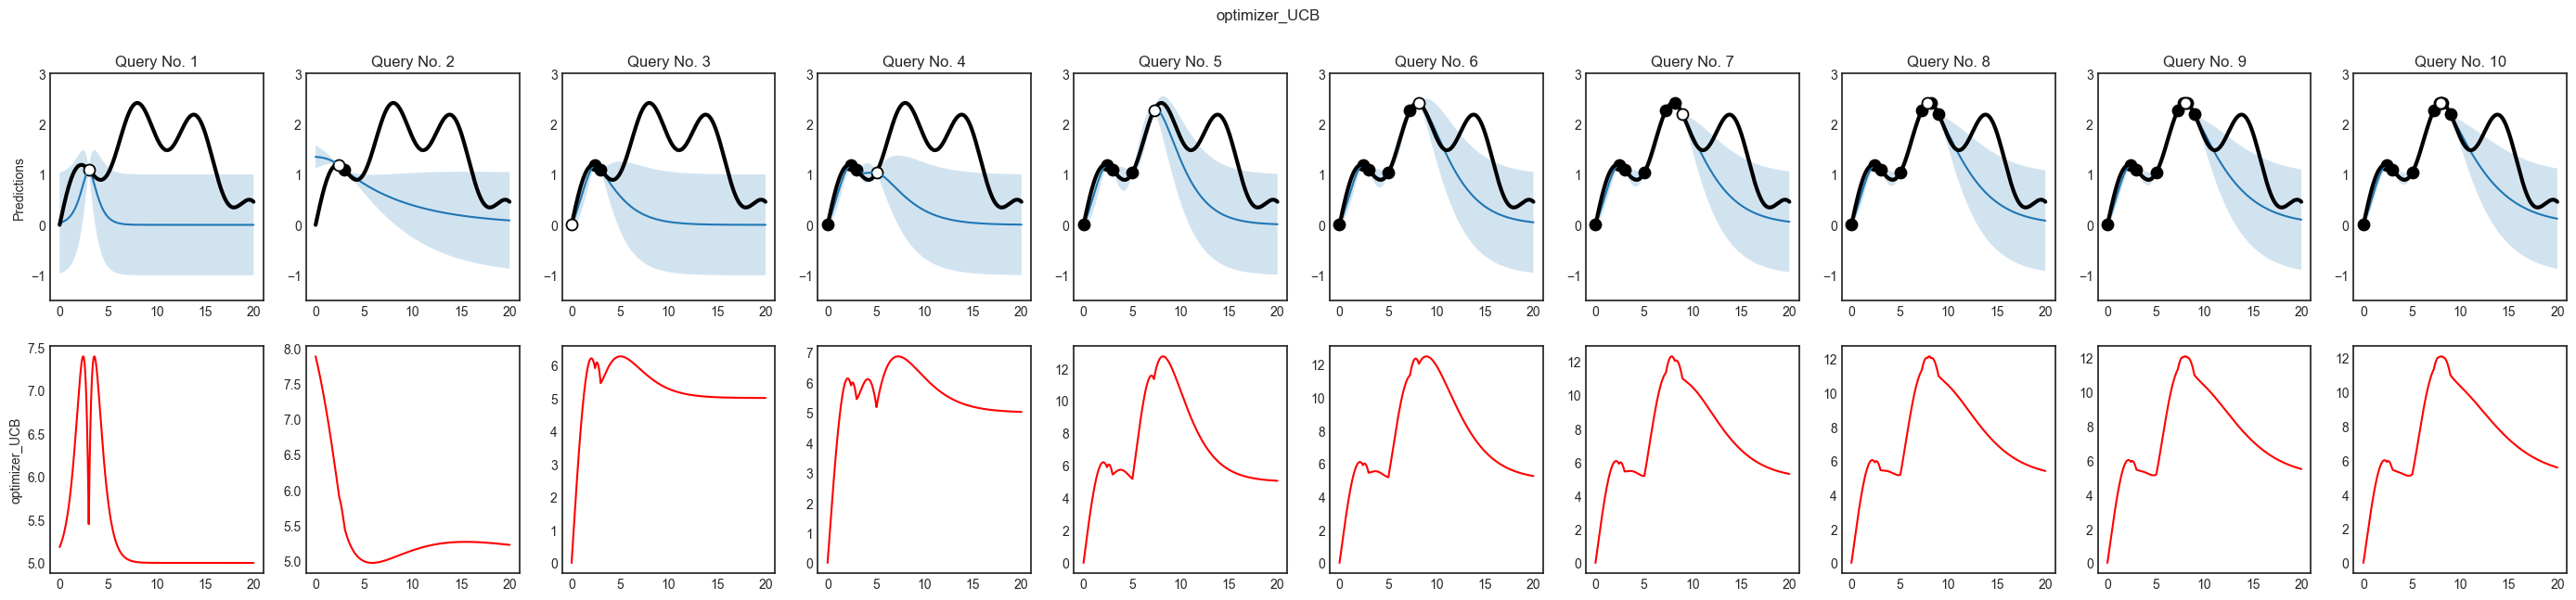

In [3]:
for acquisition, query_strategy in acquisitions:

    # initializing the optimizer
    optimizer = BayesianOptimizer(
        estimator=GaussianProcessRegressor(kernel=kernel),
        X_training=X_initial, y_training=y_initial,
        query_strategy=query_strategy
    )

    # plotting the initial estimation
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(35, 7))
        plt.suptitle(acquisition.__name__)
        for n_query in range(10):
            # plot current prediction
            plt.subplot(2, 10, n_query + 1)
            plt.title('Query No. %d' %(n_query + 1))
            if n_query == 0:
                plt.ylabel('Predictions')
            plt.xlim([-1.0, 21.0])
            plt.ylim([-1.5, 3])
            pred, std = optimizer.predict(X.reshape(-1, 1), return_std=True)
            utility_score = acquisition(optimizer, X)
            plt.plot(X, pred)
            plt.fill_between(X.reshape(-1, ), pred.reshape(-1, ) - std, pred.reshape(-1, ) + std, alpha=0.2)
            plt.plot(X, y, c='k', linewidth=3)
            # plotting acquired values
            plt.scatter(optimizer.X_training[-1], optimizer.y_training[-1], c='w', s=40, zorder=20)
            plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=80, zorder=1)

            plt.subplot(2, 10, 10 + n_query + 1)
            if n_query == 0:
                plt.ylabel(acquisition.__name__)
            plt.plot(X, 5 * utility_score, c='r')
            plt.xlim([-1.0, 21.0])

            # query
            query_idx, query_inst = optimizer.query(X)
            optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
        plt.show()